In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')
import tensorflow as tf
import tensorflow.keras as k
import pandas as pd
import numpy as np
import test_submit
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[6], 'GPU')

In [4]:
train = pd.read_pickle('../inputs/dataset/train.pkl')
investment_id = train.pop('investment_id')
time_id = train.pop('time_id')
y = train.pop('target')

In [5]:
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = k.layers.IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))

2022-03-07 22:50:38.807582: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 22:50:39.358804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38411 MB memory:  -> device: 6, name: A100-SXM4-40GB, pci bus id: 0000:b7:00.0, compute capability: 8.0
2022-03-07 22:50:39.762176: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        114560      integer_lookup[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32)           0           embedding[0][0]                  
______________________________________________________________________________________________

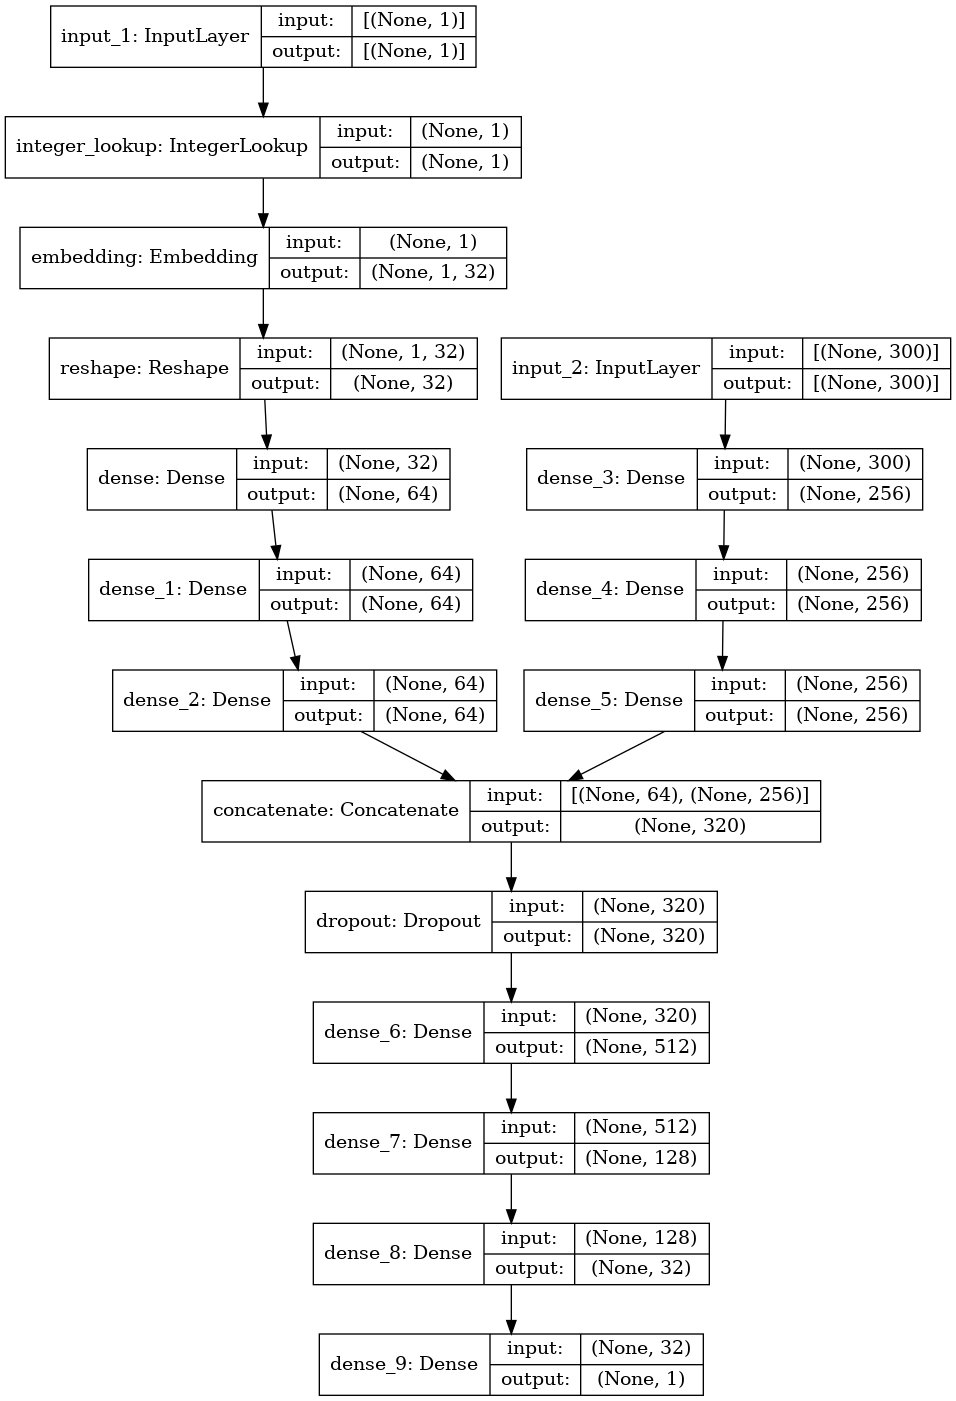

In [6]:
features = [f'f_{i}' for i in range(300)]
batch_size = 1024
epochs = 30

tf.config.run_functions_eagerly(True)


# @tf.function
# def correlation(x, y, axis=-2):
#     # x = tf.convert_to_tensor(x)
#     y = math_ops.cast(y, x.dtype)
#     n = tf.cast(tf.shape(x)[axis], x.dtype)
#     xsum = tf.reduce_sum(x, axis=axis)
#     ysum = tf.reduce_sum(y, axis=axis)
#     xmean = xsum / n
#     ymean = ysum / n
#     xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
#     yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
#     cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
#     if xvar* yvar == 0:
#         corr = 0
#     else:
#         corr = cov / tf.sqrt(xvar * yvar)
#     return tf.constant(1.0, dtype=x.dtype) - corr



def get_model():
    activation = 'relu'
    kernel_regularizer = None
    # activation = 'swish'
    # kernel_regularizer = 'l2'

    investment_id_inputs = k.Input((1, ), dtype=tf.uint16)
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = k.layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = k.layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = k.layers.Dense(64, activation=activation)(investment_id_x)
    investment_id_x = k.layers.Dense(64, activation=activation)(investment_id_x)
    investment_id_x = k.layers.Dense(64, activation=activation)(investment_id_x)

    feature_inputs = k.Input((300,), dtype=tf.float16)
    feature_x = k.layers.Dense(256, activation=activation)(feature_inputs)
    feature_x = k.layers.Dense(256, activation=activation)(feature_x)
    feature_x = k.layers.Dense(256, activation=activation)(feature_x)


    x = k.layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = k.layers.Dropout(.5)(x)
    x = k.layers.Dense(512, activation=activation)(x)
    x = k.layers.Dense(128, activation=activation)(x)
    x = k.layers.Dense(32, activation=activation)(x)
    output = k.layers.Dense(1)(x)

    model = k.Model(inputs=[investment_id_inputs, feature_inputs], outputs=[output])
    model.compile(optimizer=k.optimizers.Adam(), loss='mse', metrics=['mse', 'mae'])
    return model

def eval(model):
    return test_submit.eval(lambda test: model.predict(test[features]))

def make_dataset(feature, y, investment_id, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    # ds = tf.data.Dataset.from_tensor_slices((feature, y))
    if mode == "train":
        ds = ds.shuffle(4096)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

model = get_model()
model.summary()
k.utils.plot_model(model, show_shapes=True)

  13/2455 [..............................] - ETA: 32s - loss: 0.9526 - mse: 0.9526 - mae: 0.6984

2022-03-07 22:50:56.067845: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2455/2455 [==============================] - 35s 14ms/step - loss: 0.8312 - mse: 0.8312 - mae: 0.6242 - val_loss: 0.8369 - val_mse: 0.8369 - val_mae: 0.6277


2022-03-07 22:51:31.104392: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../outputs/models/my_simple_nn_0/assets
Pearson: (0.11373120452603104, 0.0)


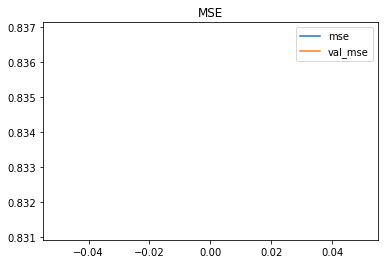

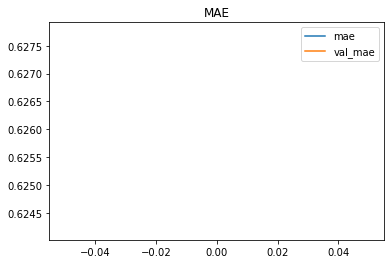

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold

models = []
kfold = KFold(5, shuffle=True, random_state=23)
# kfold = StratifiedKFold(5, shuffle=True, random_state=23)

for i, (train_indices, target_indices) in enumerate(kfold.split(train[features], investment_id)):
    X_train, X_val = train.loc[train_indices, features], train.loc[target_indices, features]
    y_train, y_val = y.loc[train_indices], y.loc[target_indices]
    investment_id_train, investment_id_val = investment_id.loc[train_indices], investment_id.loc[target_indices]
    train_ds = make_dataset(X_train, y_train, investment_id_train)
    val_ds = make_dataset(X_val, y_val, investment_id_val, mode='val')

    if True:
        checkpoint = k.callbacks.ModelCheckpoint(f'../outputs/models/my_simple_nn_{i}', save_best_only=True)
        earlystopping = k.callbacks.EarlyStopping(patience=10)

        model = get_model()
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=1,
            callbacks=[checkpoint, earlystopping]
        )

    model = k.models.load_model(f'../outputs/models/my_simple_nn_{i}')
    models.append(model)

    pearson_score = stats.pearsonr(model.predict(val_ds).ravel(), y_val.values)
    print('Pearson:', pearson_score)
    pd.DataFrame(history.history, columns=['mse', 'val_mse']).plot()
    plt.title("MSE")
    pd.DataFrame(history.history, columns=['mae', 'val_mae']).plot()
    plt.title("MAE")
    plt.show()
    break

In [9]:
history.history

{'loss': [0.8311934471130371],
 'mse': [0.8311934471130371],
 'mae': [0.6241962909698486],
 'val_loss': [0.8368633389472961],
 'val_mse': [0.8368633389472961],
 'val_mae': [0.627741277217865]}

In [86]:
def preprocess_test(feature):
    return feature, 0

def make_test_dataset(feature, investment_id, batch_size=1024):
#     ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = tf.data.Dataset.from_tensor_slices(feature)
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0).ravel()



test_df = pd.read_csv('../inputs/dataset/example_test.csv')
sample_prediction_df = pd.read_csv('../inputs/dataset/example_sample_submission.csv')


ds = make_test_dataset(test_df[features], test_df["investment_id"])
sample_prediction_df['target'] = inference(models, ds)